In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

import allantools

Welcome to JupyROOT 6.12/04


In [2]:
interp_df = pd.read_hdf('hdf5/superlong_2.h5', 'tr_df')

In [3]:
moment_df = pd.DataFrame(index=interp_df.index)
moment_df['tr_phi'] = interp_df['tr_phi'].values

print 'Calculating trolley moments.',
theta_tr = trfp.THETA_TR
for m in np.arange(17):
    tr_probes = ['tr'+str(probe) for probe in np.arange(17)]
    moment_df['tr,m'+str(m+1)] = interp_df[tr_probes].dot(theta_tr[m])
    
for station in np.arange(72):
    print '\rCalculating station ' + str(station) + ' moments.',
    fp_st = ['fp'+str(fp) for fp in trfp.STATION_PROBE_ID[station]]

    # choose proper theta matrix
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        if station == 41:
            theta_fp = trfp.THETA_FP_4_ST41
        elif (station == 37) | (station == 39):
            theta_fp = trfp.THETA_FP_4_ST37_ST39
        else:
            theta_fp = trfp.THETA_FP_4
    else:
        theta_fp = trfp.THETA_FP_6

    # step through m values
    for m in np.arange(len(trfp.STATION_PROBE_ID[station])):
        stm = 'st'+str(station)+',m'+str(m+1)
        moment_df[stm] = interp_df[fp_st].dot(theta_fp[m])
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        moment_df['st'+str(station)+',m5'] = np.nan
        moment_df['st'+str(station)+',m6'] = np.nan
        
# calculate baselines using the first 5 points (doesn't actually matter)
tr_baseline = np.empty((72,17))

df_mean =  np.mean(moment_df.iloc[0:1000], axis=0).values

for i in range(72):
    tr_baseline[i, :] = df_mean[1:18]
fp_baseline = np.reshape(df_mean[18:], (72,6))

baseline_time_1 = np.empty((72,6))
baseline_time_2 = np.empty((72,6))

baseline_time_1[:,:] = moment_df.index.values[0]
baseline_time_2[:,:] = moment_df.index.values[-1]

fp_df = moment_df.copy()

fp_df = fp_df.drop(columns=['tr_phi']+['tr,m'+str(m) for m in range(1,18)])

vtm_df = helper.vtm_calc(fp_df, baseline_time_1, baseline_time_2, tr_baseline, tr_baseline, fp_baseline, fp_baseline)

Calculating station 71 moments.                     


In [4]:
TR_X = np.array([0]
                + [1.75 * np.sin(2*np.pi/4*i) for i in np.arange(4)]
                + [3.5 * np.sin(2*np.pi/12*i) for i in np.arange(4)]
                + [3.5 * np.sin(2*np.pi/12*i) for i in np.arange(5, 12)])
TR_Y = np.array([0]
                + [-1.75 * np.cos(2*np.pi/4*i) for i in np.arange(4)]
                + [-3.5 * np.cos(2*np.pi/12*i) for i in np.arange(4)]
                + [-3.5 * np.cos(2*np.pi/12*i) for i in np.arange(5, 12)])

def __multipole(order, skew, strength, x_pos, y_pos):
    """Returns the magnitude of a B-field given multipole parameters
    and position.
    """
    # Takes a multipole strength A normalized to 4.5 cm
    r_pos = np.sqrt(x_pos**2 + y_pos**2)
    theta = np.arctan2(y_pos, x_pos)
    if skew == 0:
        b_magnitude = strength * (r_pos/4.5)**order * np.cos(order*theta)
    if skew == 1:
        b_magnitude = strength * (r_pos/4.5)**order * np.sin(order*theta)
    return b_magnitude

_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7]
_MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
_MULTS = np.array([__multipole(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], 1, TR_X, TR_Y) for i in range(14)])
_MULTS[np.abs(_MULTS) < 1.0e-9] = 0 

THETA_TR = np.linalg.pinv(np.transpose(_MULTS))
THETA_TR = np.insert(THETA_TR, 8, np.zeros(14), 1)
THETA_TR = np.insert(THETA_TR, 12, np.zeros(17), 0)
THETA_TR = np.append(THETA_TR, np.zeros([2,17]), 0)
THETA_TR[np.abs(THETA_TR) < 1.0e-9] = 0

In [5]:
moment_df_2 = pd.DataFrame(index=interp_df.index)
moment_df_2['tr_phi'] = interp_df['tr_phi'].values

print 'Calculating trolley moments.',
theta_tr = THETA_TR
for m in np.arange(17):
    tr_probes = ['tr'+str(probe) for probe in np.arange(17)]
    moment_df_2['tr,m'+str(m+1)] = interp_df[tr_probes].dot(theta_tr[m])
    
for station in np.arange(72):
    print '\rCalculating station ' + str(station) + ' moments.',
    fp_st = ['fp'+str(fp) for fp in trfp.STATION_PROBE_ID[station]]

    # choose proper theta matrix
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        if station == 41:
            theta_fp = trfp.THETA_FP_4_ST41
        elif (station == 37) | (station == 39):
            theta_fp = trfp.THETA_FP_4_ST37_ST39
        else:
            theta_fp = trfp.THETA_FP_4
    else:
        theta_fp = trfp.THETA_FP_6

    # step through m values
    for m in np.arange(len(trfp.STATION_PROBE_ID[station])):
        stm = 'st'+str(station)+',m'+str(m+1)
        moment_df_2[stm] = interp_df[fp_st].dot(theta_fp[m])
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        moment_df_2['st'+str(station)+',m5'] = np.nan
        moment_df_2['st'+str(station)+',m6'] = np.nan
        
# calculate baselines using the first 5 points (doesn't actually matter)
tr_baseline = np.empty((72,17))

df_mean =  np.mean(moment_df_2.iloc[0:1000], axis=0).values

for i in range(72):
    tr_baseline[i, :] = df_mean[1:18]
fp_baseline = np.reshape(df_mean[18:], (72,6))

baseline_time_1 = np.empty((72,6))
baseline_time_2 = np.empty((72,6))

baseline_time_1[:,:] = moment_df_2.index.values[0]
baseline_time_2[:,:] = moment_df_2.index.values[-1]

fp_df_2 = moment_df_2.copy()

fp_df_2 = fp_df_2.drop(columns=['tr_phi']+['tr,m'+str(m) for m in range(1,18)])

vtm_df_2 = helper.vtm_calc(fp_df_2, baseline_time_1, baseline_time_2, tr_baseline, tr_baseline, fp_baseline, fp_baseline)

Calculating station 71 moments.                     


In [7]:
dt = 1000
start = np.ceil(vtm_df.index.values[0]/dt)*dt
end = np.floor(vtm_df.index.values[-1]/dt)*dt

bin_edges = np.arange(start, end+dt, dt)
bin_centers = np.arange(start, end, dt)+dt/2

interp_bin_df = interp_df.groupby(pd.cut(interp_df.index, bin_edges)).mean()
interp_bin_df.index = bin_centers

vtm_bin_df = vtm_df.groupby(pd.cut(vtm_df.index, bin_edges)).mean()
vtm_bin_df.index = bin_centers

vtm_bin_df_2 = vtm_df_2.groupby(pd.cut(vtm_df_2.index, bin_edges)).mean()
vtm_bin_df_2.index = bin_centers

moment_bin_df = moment_df.groupby(pd.cut(moment_df.index, bin_edges)).mean()
moment_bin_df.index = bin_centers

moment_bin_df_2 = moment_df_2.groupby(pd.cut(moment_df_2.index, bin_edges)).mean()
moment_bin_df_2.index = bin_centers


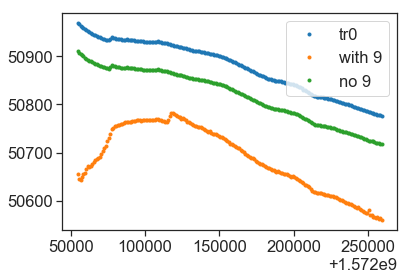

In [9]:
plt.plot(interp_bin_df.index.values, interp_bin_df['tr0'].values, '.', label='tr0')
plt.plot(moment_bin_df.index.values, moment_bin_df['tr,m1'].values, '.', label='with 9')
plt.plot(moment_bin_df_2.index.values, moment_bin_df_2['tr,m1'].values, '.', label='no 9')

plt.legend()

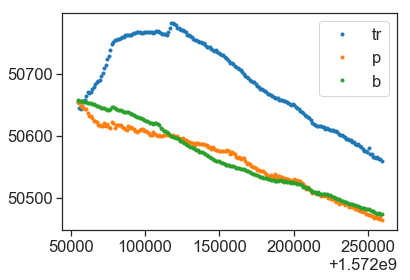

In [11]:
azi = trfp.STATION_BARCODE_PHI
weight_4 = (azi[6] - azi[5])/(azi[6] - azi[4])
weight_6 = (azi[5] - azi[4])/(azi[6] - azi[4])

plt.plot(moment_bin_df.index.values, moment_bin_df['tr,m1'].values, '.', label='tr')
plt.plot(vtm_bin_df.index.values, vtm_bin_df['st5,m1'].values, '.', label='p')
plt.plot(vtm_bin_df.index.values, (weight_4*vtm_bin_df['st4,m1']+weight_6*vtm_bin_df['st6,m1']).values, '.', label='b')
plt.legend()

4.972544054637377
5.711594846758448
2.452929143498816
14.76637745240978


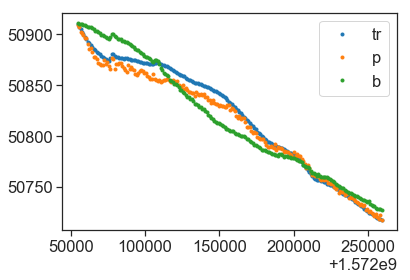

In [14]:
azi = trfp.STATION_BARCODE_PHI
weight_4 = (azi[6] - azi[5])/(azi[6] - azi[4])
weight_6 = (azi[5] - azi[4])/(azi[6] - azi[4])

# plt.plot(moment_df_2.index.values, moment_df_2['tr,m1'].values, '.')
# plt.plot(moment_df.index.values, moment_df['tr,m1'].values, '.')
plt.plot(moment_bin_df_2.index.values, moment_bin_df_2['tr,m1'].values, '.', label='tr')
plt.plot(vtm_bin_df_2.index.values, vtm_bin_df_2['st5,m1'].values, '.', label='p')
# plt.plot(vtm_bin_df_2.index.values, vtm_bin_df_2['st5,m1'].values - 2.68*vtm_bin_df_2['st5,m5'].values - 5185, '.')
plt.plot(vtm_bin_df_2.index.values, (weight_4*vtm_bin_df_2['st4,m1']+weight_6*vtm_bin_df_2['st6,m1']).values, '.', label='b')
plt.legend()

print np.mean(moment_bin_df_2['tr,m1'].values - vtm_bin_df_2['st5,m1'].values)
print np.std(moment_bin_df_2['tr,m1'].values - vtm_bin_df_2['st5,m1'].values)

print np.mean(moment_bin_df_2['tr,m1'].values - (weight_4*vtm_bin_df_2['st4,m1']+weight_6*vtm_bin_df_2['st6,m1']).values)
print np.std(moment_bin_df_2['tr,m1'].values - (weight_4*vtm_bin_df_2['st4,m1']+weight_6*vtm_bin_df_2['st6,m1']).values)

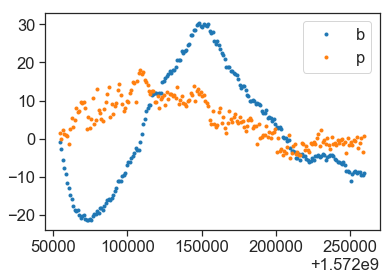

In [15]:
plt.plot(vtm_bin_df_2.index.values, moment_bin_df_2['tr,m1'].values - (weight_4*vtm_bin_df_2['st4,m1']+weight_6*vtm_bin_df_2['st6,m1']).values, '.', label='b')
plt.plot(vtm_bin_df_2.index.values, moment_bin_df_2['tr,m1'].values - vtm_bin_df_2['st5,m1'], '.', label='p')
plt.legend()


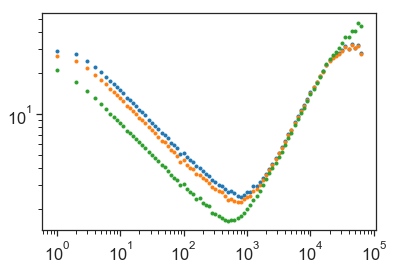

In [35]:
azi = trfp.STATION_BARCODE_PHI
weight_4 = (azi[6] - azi[5])/(azi[6] - azi[4])
weight_6 = (azi[5] - azi[4])/(azi[6] - azi[4])

taus_in = np.round(np.power(10, np.arange(0,6,0.05)))

taus, adev, _, _ = allantools.adev((moment_df['tr,m1']-(vtm_df_2['st5,m1']-0*vtm_df_2['st5,m2'])).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.adev((moment_df['tr,m1']-(vtm_df_2['st5,m1']-0.22222*vtm_df_2['st5,m2'])).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.adev((moment_df['tr,m1']-(vtm_df_2['st5,m1']-2.68*vtm_df_2['st5,m5'])).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.adev((moment_df['tr,m1']-weight_4*vtm_df_2['st4,m1']-weight_6*vtm_df_2['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')



In [ ]:
taus_in = np.round(np.power(10, np.arange(0,6,0.05)))

fig, axs = plt.subplots(1,1)

taus, adev, _, _ = allantools.adev((moment_df_2['tr,m1']-(vtm_df_2['st5,m1']-0*vtm_df_2['st5,m5'])).values, data_type='freq', rate=1, taus=taus_in)
axs.loglog(taus, adev, '.', label='Purcell')

taus, adev, _, _ = allantools.adev((moment_df_2['tr,m1']-(vtm_df_2['st5,m1']-2.68*vtm_df_2['st5,m5'])).values, data_type='freq', rate=1, taus=taus_in)
axs.loglog(taus, adev, '.', label='Purcell, no correction')

taus, adev, _, _ = allantools.adev((moment_df_2['tr,m1']-weight_4*vtm_df_2['st4,m1']-weight_6*vtm_df_2['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
axs.loglog(taus, adev, '.', label='Bloch-style')

axs.set_xlabel('Averaging time (sec)')
axs.set_ylabel('Allan deviation (Hz)')

axs.legend()

fig.set_size_inches(8,6)
fig.tight_layout()

In [ ]:
m_a = 'm1'
m_b = 'm1'

fig, axs = plt.subplots(3,1)

axs[0].plot(moment_bin_df['tr,'+m_a], vtm_bin_df['st5,'+m_b], '.')
axs[1].plot(moment_bin_df['tr,'+m_a], vtm_bin_df['st5,'+m_b] - 2.68 * vtm_bin_df['st5,m5'], '.')
axs[2].plot(moment_bin_df['tr,'+m_a], weight_4*vtm_bin_df['st4,'+m_b]+weight_6*vtm_bin_df['st6,'+m_b], '.')

fig.set_size_inches(8,8)
fig.tight_layout()

In [ ]:
m_a = 'm5'
m_b = 'm5'

fig, axs = plt.subplots(2,1)

axs[0].plot(moment_bin_df_2['tr,'+m_a], vtm_bin_df_2['st5,'+m_b], '.')
axs[1].plot(moment_bin_df_2['tr,'+m_a], vtm_bin_df_2['st5,'+m_b] - 2.68 * vtm_bin_df_2['st5,m5'], '.')
# axs[2].plot(moment_bin_df_2['tr,'+m_a], weight_4*vtm_bin_df_2['st4,'+m_b]+weight_6*vtm_bin_df_2['st6,'+m_b], '.')

fig.set_size_inches(8,6)
fig.tight_layout()

In [ ]:
plt.plot(moment_bin_df_2.index.values, moment_bin_df_2['tr,m8'], '.')